In [32]:
from performance_figure_functions import *
from predictor_comparisons import *
from general_funcs import *


In [33]:

def strip_clashing(x, chain):
    if x != 'select clashing_res, ':
        chains_list = re.findall(r'\((.*?)\)',x)
        #print (chains_list)
        for chain_curr in chains_list:
            if chain == 'A' and 'A' in chain_curr:
                return len(chain_curr.split(' ')[-1].split(","))
            elif chain == 'B' and 'B' in chain_curr:
                return len(chain_curr.split(' ')[-1].split(","))
            else:
                return -1
    else:
        return 0
    

def plot_regression(df, savename, w =4, h =2 ):#, c_scheme = 'copper'):
    fig, ax = plt.subplots()#(2,1, sharex= True) #plot AUCROC, MCC, n_features
    # the size of A4 paper
    fig.set_size_inches(w,h)
    
    plt.xlabel('')
    #plotting baseline AUCROC for imbalanced class +
    s =sns.barplot(data = df,
                x = 'dataset', 
                y = 'test_spearman', )
    #s._legend.remove()
    ax.set_ylim(0,1)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.xticks(rotation=90)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.savefig(savename, dpi = 300)
    plt.show()

def plot_classif(df, savename, w =4, h =2 ):#, c_scheme = 'copper'):
    fig, ax = plt.subplots()

    fig.set_size_inches(w,h)
    
    plt.xlabel('')
    s =sns.barplot(data = df,
                x = 'dataset', 
                y = 'avgpr_test', )
    #s._legend.remove()
    ax.set_ylim(0,1)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.xticks(rotation=90)
    plt.legend([],[], frameon=False)
    plt.xlabel('')
    
    plt.savefig(savename, dpi = 300)
    plt.show()
    

In [34]:
#v2 regression 

v2_inputs, cols_not_model = load_dataset_single('malb_v3', 'af', 'malb')
v2_malbs, cols_not_model_malbs = load_dataset_single('v3', 'af', 'ncip')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/af3_with_resi_strs.csv')
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')

get_trained_model_v3_t1, x_scaler, y_scaler, list_cols = padj_get_model_regression('malb_v3', 'af',  'malb', '07_23_malb_regression_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict(x_train_scaled)
preds = y_scaler.inverse_transform(preds)
all_columns_v2['preds'] = preds
avgs_test = all_columns_v2.groupby(['ppi']).mean()

rows = []

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
rows = []
rows.append({'dataset': 'pred_ncip_malb_v3_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)
rows.append({'dataset': 'z_pred_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

rows_df = pd.DataFrame(rows)

train    430
test      47
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
best l1:      dataset r2_cutoff  l2_penalty  train_r2_not_avgd  train_r2  \
17  malb_v3        af    2.511886           0.214887  0.268538   

    train_spearman_not_avgd  train_spearman  test_r2_not_avgd   test_r2  \
17                 0.329884        0.364007          0.102084  0.123915   

    test_spearman_not_avgd  test_spearman  n_non_zero  
17                0.315006       0.344241           4   2.5118864315095824
0.2615266064471938 0.08133139413168025 0.8423772609819121 0.5480488437073898
0.28065203078786444 0.09139041094912792 0.875 0.6744331065759637


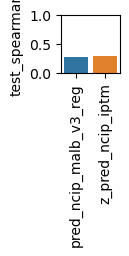

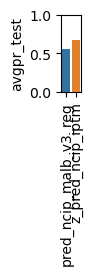

In [36]:
plot_regression(rows_df, 'pred_ncip_malb_reg.svg', 0.75,0.75)
plot_classif(rows_df, 'pred_ncip_malb_class.svg', 0.25,1)

In [37]:
#usign the v2 t0 model 
v2_inputs, cols_not_model = load_dataset_single('malb_v3', 'af', 'malb')#load_dataset_single('v2', 'af')
v2_malbs, cols_not_model_malbs = load_dataset_single('v3', 'af', 'ncip')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/af3_with_resi_strs.csv')
#v2_preds = v2_preds[v2_preds['rosetta-protocol'] == 'rosetta-flex-bb'].copy().reset_index(drop = True)
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')


get_trained_model_v3_t1, x_scaler, list_cols = padj_get_model_classif('malb_v3', 'af',  'malb', '07_23_malb_classification_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict_proba(x_train_scaled)
all_columns_v2['preds'] = preds[:,1]
avgs_test = all_columns_v2.groupby(['ppi']).mean()

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
rows = []
rows.append({'dataset': 'pred_ncip_malb_v3_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)

rows.append({'dataset': 'z_pred_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

rows_df = pd.DataFrame(rows)
#average and plot

train    430
test      47
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
best l1:      dataset r2_cutoff   l2_penalty  rocauc_train_not_avgd  rocauc_train  \
17  malb_v3        af  1584.893192               0.880176      0.899319   

    avgpr_train_not_avgd  avgpr_train  rocauc_test_not_avgd  rocauc_test  \
17              0.443172     0.551118              0.735152     0.755411   

    avgpr_test_not_avgd  avgpr_test  n_non_zero  
17             0.810945     0.81563           4   1584.8931924611177
0.2589066312770238 0.09018146210708491 0.8604651162790697 0.4926931456343221
0.28065203078786444 0.09139041094912792 0.875 0.6744331065759637


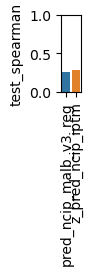

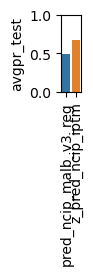

In [38]:
plot_regression(rows_df, 'pred_ncip_malb.svg', 0.25,1)
plot_classif(rows_df, 'pred_ncip_malb.svg', 0.25,1)

In [39]:
#predict malbs with ncip 
#usign the v3 model to predict ncips (regression)
v2_inputs, cols_not_model = load_dataset_single('v3', 'af', 'ncip')
v2_malbs, cols_not_model_malbs = load_dataset_single('malb_v3', 'af', 'malb')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/AF2_rosetta_merged-AF-v3.csv')
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')

get_trained_model_v3_t1, x_scaler, y_scaler, list_cols = padj_get_model_regression('v3', 'af',  'ncip', '07_23_ncip_regression_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict(x_train_scaled)
preds = y_scaler.inverse_transform(preds)
all_columns_v2['preds'] = preds
avgs_test = all_columns_v2.groupby(['ppi']).mean()

rows = []

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
rows = []
rows.append({'dataset': 'v3_ncip_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)
rows.append({'dataset': 'v3_z_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

#rows_df = pd.DataFrame(rows)

#plot_regression(rows_df, 'pred_malb_ncip.svg', 0.25,1)
#plot_classif(rows_df, 'pred_ncip_malb.svg', 0.25,1)

train    127
test      14
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff  l2_penalty  train_r2_not_avgd  train_r2  \
30      v3        af         0.1           0.046049  0.093209   

    train_spearman_not_avgd  train_spearman  test_r2_not_avgd   test_r2  \
30                 0.117527        0.172701          0.109933  0.210109   

    test_spearman_not_avgd  test_spearman  n_non_zero  
30                0.417348       0.520879           4   0.1
0.3513161639488036 0.17059073854079096 0.8536679536679537 0.4472080253670505
0.4056009689644434 0.3137720985848536 0.8992979992979993 0.61665761025332


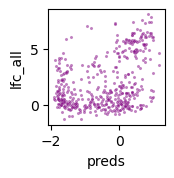

In [40]:
#S11 E-F
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = avgs_test, x = 'preds', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
#fig.set_size_inches(0.6,1)
fig.set_size_inches(1.5,1.5)
#plt.xscale('log')
plt.savefig('class_ncip_pred_malb_v2.svg')

train    127
test      14
Name: order_padj_sets, dtype: int64


train    430
test      47
Name: order_padj_sets, dtype: int64
train    127
test      14
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff  l2_penalty  train_r2_not_avgd  train_r2  \
23      v2        af    0.063096           0.050917  0.078368   

    train_spearman_not_avgd  train_spearman  test_r2_not_avgd   test_r2  \
23                 0.083782        0.118872          0.451936  0.622535   

    test_spearman_not_avgd  test_spearman  n_non_zero  
23                 0.66167       0.648352           3   0.0630957344480193
0.3619860512295231 0.1358509162706162 0.84991224991225 0.44712398072315845
0.4223940810535448 0.2455433125717843 0.8776412776412776 0.5363317094746091


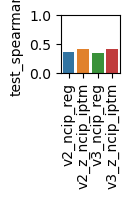

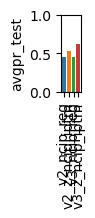

In [41]:
#predict malbs with ncip 
#usign the v3 model to predict ncips (regression)
v2_inputs, cols_not_model = load_dataset_single('v2', 'af', 'ncip')
v2_malbs, cols_not_model_malbs = load_dataset_single('malb_v2', 'af', 'malb')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/AF2_rosetta_merged-v2.csv')
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')

get_trained_model_v3_t1, x_scaler, y_scaler, list_cols = padj_get_model_regression('v2', 'af',  'ncip', '07_23_ncip_regression_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict(x_train_scaled)
preds = y_scaler.inverse_transform(preds)
all_columns_v2['preds'] = preds
avgs_test = all_columns_v2.groupby(['ppi']).mean()

#rows = []

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
#rows = []
rows.append({'dataset': 'v2_ncip_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)
rows.append({'dataset': 'v2_z_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

rows_df = pd.DataFrame(rows)
rows_df = rows_df.sort_values('dataset')
plot_regression(rows_df, 'pred_malb_ncip.svg', 0.75,0.75)
plot_classif(rows_df, 'pred_ncip_malb.svg', 0.25,1)

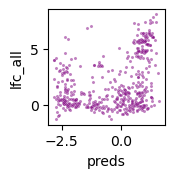

In [42]:
#S11 E-F
fig, axes = plt.subplots(1, sharex = False)
sns.scatterplot(data = avgs_test, x = 'preds', y = 'lfc_all', alpha = 0.5, color = 'purple', s= 5)
#fig.set_size_inches(0.6,1)
fig.set_size_inches(1.5,1.5)
#plt.xscale('log')
plt.savefig('class_ncip_pred_malb_v2.svg')

train    127
test      14
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
best l1:      dataset r2_cutoff   l2_penalty  rocauc_train_not_avgd  rocauc_train  \
17  malb_v3        af  1584.893192               0.880176      0.899319   

    avgpr_train_not_avgd  avgpr_train  rocauc_test_not_avgd  rocauc_test  \
17              0.443172     0.551118              0.735152     0.755411   

    avgpr_test_not_avgd  avgpr_test  n_non_zero  
17             0.810945     0.81563           4   1584.8931924611177
0.3756836120411691 0.2904156704461205 0.8996840996840997 0.6114296646181403
0.4056009689644434 0.3137720985848536 0.8992979992979993 0.61665761025332


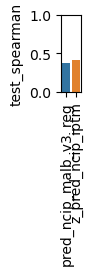

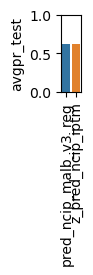

In [9]:
#usign the v2 t0 model 

v2_inputs, cols_not_model = load_dataset_single('v3', 'af', 'ncip')
v2_malbs, cols_not_model_malbs = load_dataset_single('malb_v3', 'af', 'malb')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/AF2_rosetta_merged-AF-v3.csv')
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')


get_trained_model_v3_t1, x_scaler, list_cols = padj_get_model_classif('malb_v3', 'af',  'malb', '07_23_malb_classification_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict_proba(x_train_scaled)
all_columns_v2['preds'] = preds[:,1]
avgs_test = all_columns_v2.groupby(['ppi']).mean()

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
rows = []
rows.append({'dataset': 'pred_ncip_malb_v3_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)

rows.append({'dataset': 'z_pred_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

rows_df = pd.DataFrame(rows)
#average and plot
plot_regression(rows_df, 'pred_ncip_malb.svg', 0.25,1)
plot_classif(rows_df, 'pred_ncip_malb.svg', 0.25,1)

train    127
test      14
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
train    430
test      47
Name: order_padj_sets, dtype: int64
best l1:     dataset r2_cutoff    l2_penalty  rocauc_train_not_avgd  rocauc_train  \
8  malb_v2        af  63095.734448               0.853075      0.881783   

   avgpr_train_not_avgd  avgpr_train  rocauc_test_not_avgd  rocauc_test  \
8              0.299783     0.443517              0.696364     0.720779   

   avgpr_test_not_avgd  avgpr_test  n_non_zero  
8             0.804524    0.815582           4   63095.73444801943
0.40010435373328296 0.22709889699430197 0.8764829764829765 0.5287730841620432
0.4223940810535448 0.2455433125717843 0.8776412776412776 0.5363317094746091


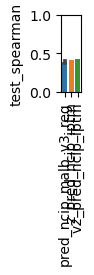

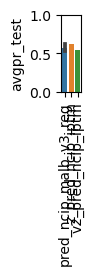

In [10]:
#usign the v2 t0 model 

v2_inputs, cols_not_model = load_dataset_single('v2', 'af', 'ncip')
v2_malbs, cols_not_model_malbs = load_dataset_single('malb_v2', 'af', 'malb')
gather_columns = list(set(v2_inputs.columns).difference(set(cols_not_model)))
other_cols = [x for x in gather_columns if x not in v2_malbs.columns ]
in_series = [x for x in gather_columns if x in v2_malbs.columns]
 
#v2 of malb predictions
v2_preds = pd.read_csv('./af_prediction_values_rosetta_energy_terms/AF2_rosetta_merged-v2.csv')
v2_preds.drop(columns = ['timed'], inplace = True)
v2_preds.drop(columns = 'clashing_res', inplace=True)
#remove columns which are always the same 
v2_preds['fraction_int_all'] = v2_preds.IA_nres_int/v2_preds.IA_nres_all.fillna(1)
v2_preds['fraction_all'] = v2_preds.nres_int/v2_preds.nres_all.fillna(1)
v2_preds['id1'] = v2_preds.id1.apply(lambda x: x.replace('__','_'))
v2_preds['id2'] = v2_preds.id2.apply(lambda x: x.replace('__','_'))
v2_preds['ppi'] = v2_preds.id1 + '_' + v2_preds.id2
v2_preds.rename(columns = {'model_number':'model', 'plddt': 'mean_plddt'}, inplace = True)
v2_preds['type'] = 'v2'
v2_preds['msa_depth'] = 2
v2_preds['new_ppi'] = v2_preds.apply(lambda row: row.ppi + '_' + str(row.model), axis  =1 )
v2_preds['over_thresh'] = v2_preds.iptm > 0.75
#drop duplicate new_ppi
v2_preds = v2_preds.drop_duplicates('new_ppi', keep = 'first')
v2_preds_other = v2_preds[['new_ppi', 'over_thresh'] + other_cols]
all_columns_v2 = v2_malbs.merge(v2_preds_other, on = 'new_ppi', how = 'inner')


get_trained_model_v3_t1, x_scaler, list_cols = padj_get_model_classif('malb_v2', 'af',  'malb', '07_23_malb_classification_default.csv', False, False)
full_train = all_columns_v2[list_cols].to_numpy()
x_train_scaled = x_scaler.transform(full_train)
preds = get_trained_model_v3_t1.predict_proba(x_train_scaled)
all_columns_v2['preds'] = preds[:,1]
avgs_test = all_columns_v2.groupby(['ppi']).mean()

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['preds']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['preds']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['preds'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['preds'] )

print (sr_test, pr_test,aucroc,avg_pr)
rows.append({'dataset': 'pred_ncip_malb_v3_reg', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

sr_test = spearmanr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]
pr_test = pearsonr(avgs_test['lfc_all'], (avgs_test['iptm']))[0]**2
aucroc = roc_auc_score(avgs_test['binned'], avgs_test['iptm'] )
avg_pr = average_precision_score(avgs_test['binned'], avgs_test['iptm'] )
print (sr_test, pr_test,aucroc,avg_pr)

rows.append({'dataset': 'v2_pred_ncip_iptm', 'rocauc_test':aucroc, 'avgpr_test': avg_pr,'test_spearman':sr_test, 'test_r2': pr_test  })

rows_df = pd.DataFrame(rows)
#average and plot
plot_regression(rows_df, 'pred_ncip_malb.svg', 0.25,1)
plot_classif(rows_df, 'pred_ncip_malb.svg', 0.25,1)